In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2023-01-12 09:48:46.359533+01:00


# 0. import libraries, general settings

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

/Users/npapadop/miniconda3/envs/samap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(42)))

# 1. Set up annotation

In [5]:
hmmer = pd.read_csv('../data/profile/slac_hmmer.emapper.annotations', engine='python', skiprows=4, skipfooter=3, sep='\t')
hmmer['gene_id'] = hmmer['#query'].str.split('_').str[:2].str.join('_')

# read foldseek annotation and keep relevant columns
annot = pd.read_csv("../data/revision/spongilla_lut.tsv", sep='\t')

annot = annot.join(hmmer.set_index('gene_id'), on='gene_id')

annot_nodoubl = annot.sort_values('bit score', ascending=False).drop_duplicates('gene_id')
keep = ['gene_id', 'Preferred_name_seq', 'Preferred_name_struct', 'Preferred_name' , 'Description_seq', 'Description_struct', 'Description', 'Function [CC]', 'PFAMs_seq', 'PFAMs_struct']
annot_nodoubl = annot_nodoubl[keep]

annot_nodoubl.columns = ['gene_id', 'Preferred_name_seq', 'Preferred_name_struct', 'Preferred_name_hmmer' , 'Description_seq', 'Description_struct', 'Description_hmmer', 'Function [CC]', 'PFAMs_seq', 'PFAMs_struct']

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_21230/3664721023.py:5: DtypeWarning: Columns (6,7,29) have mixed types. Specify dtype option on import or set low_memory=False.
  annot = pd.read_csv("../data/revision/spongilla_lut.tsv", sep='\t')


# 1. Read single-cell data

In [6]:
adata = sc.read('../data/revision/spongilla_basic.h5ad')

# 2. Set up gene annotation

In [7]:
# create a naked gene_id column to merge on
adata.var['gene_id'] = adata.var.index.str.split().str[0].str.replace('-', '_')
adata.var['legacy name'] = adata.var.index.values
adata.var.set_index('gene_id', inplace=True)

adata.var = adata.var.join(annot_nodoubl.set_index('gene_id'), how='left')

To facilitate marker gene plotting but also counting the number of annotated genes we will create new columns in the `.var` slot that will hold the sequence based names, structure based names, and combinations thereof, which will be the most comprehensive.

First we'll start by finding the different annotation levels - named genes, described genes, and unannotated genes - both for sequence-based and structure-based annotation.

In [8]:
seq_isnan = adata.var["Preferred_name_seq"].isnull()
seq_missing = adata.var["Preferred_name_seq"] == "-"
seq_no_desc = adata.var["Description_seq"].isnull()
seq_desc_mis = adata.var["Description_seq"] == "-"

struct_isnan = adata.var["Preferred_name_struct"].isnull()
struct_missing = adata.var["Preferred_name_struct"] == "-"
struct_no_desc = adata.var["Description_struct"].isnull()
struct_desc_mis = adata.var["Description_struct"] == "-"

hmmer_isnan = adata.var["Preferred_name_hmmer"].isnull()
hmmer_missing = adata.var["Preferred_name_hmmer"] == "-"
hmmer_no_desc = adata.var["Description_hmmer"].isnull()
hmmer_desc_mis = adata.var["Description_hmmer"] == "-"

seq_has_name = ~(seq_isnan | seq_missing)
seq_has_desc = ~(seq_no_desc | seq_desc_mis)
struct_has_name = ~(struct_isnan | struct_missing)
struct_has_desc = ~(struct_no_desc | struct_desc_mis)
hmmer_has_name = ~(hmmer_isnan | hmmer_missing)
hmmer_has_desc = ~(hmmer_no_desc | hmmer_desc_mis)

In [9]:
adata.var['gene_id'] = adata.var.index.values

Now we will combine the masks to build the best sequence annotation by using the gene IDs and the emapper fields

In [10]:
# build best sequence annotation
has_seq_desc_but_no_seq_name = seq_has_desc & ~seq_has_name
seq_unannotated = ~(seq_has_name | has_seq_desc_but_no_seq_name)
seq_named = adata.var["gene_id"][seq_has_name] + " | " + "[" + adata.var["Preferred_name_seq"][seq_has_name] + "]"
seq_described = adata.var["gene_id"][has_seq_desc_but_no_seq_name] + " | [" + adata.var["Description_seq"][has_seq_desc_but_no_seq_name] +"]"
seq_unnamed = adata.var["gene_id"][seq_unannotated]
seq_names = pd.DataFrame(seq_named.append(seq_described).append(seq_unnamed))
seq_names.columns = ['best seq. name']

same for structure-based annotation

In [11]:
# build best structure annotation
has_struct_desc_but_no_struct_name = struct_has_desc & ~struct_has_name
struct_unannotated = ~(struct_has_name | has_struct_desc_but_no_struct_name)
struct_named = adata.var["gene_id"][struct_has_name] + " | (" + adata.var["Preferred_name_struct"][struct_has_name] + ')'
struct_described = adata.var["gene_id"][has_struct_desc_but_no_struct_name] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_struct_name] + ")"
struct_unnamed = adata.var["gene_id"][struct_unannotated]
struct_names = pd.DataFrame(struct_named.append(struct_described).append(struct_unnamed))
struct_names.columns = ['best struct. name']

...and for HMMER:

In [12]:
# build best hmmeruence annotation
has_hmmer_desc_but_no_hmmer_name = hmmer_has_desc & ~hmmer_has_name
hmmer_unannotated = ~(hmmer_has_name | has_hmmer_desc_but_no_hmmer_name)
hmmer_named = adata.var["gene_id"][hmmer_has_name] + " | " + "[" + adata.var["Preferred_name_hmmer"][hmmer_has_name] + "]"
hmmer_described = adata.var["gene_id"][has_hmmer_desc_but_no_hmmer_name] + " | [" + adata.var["Description_hmmer"][has_hmmer_desc_but_no_hmmer_name] +"]"
hmmer_unnamed = adata.var["gene_id"][hmmer_unannotated]
hmmer_names = pd.DataFrame(hmmer_named.append(hmmer_described).append(hmmer_unnamed))
hmmer_names.columns = ['best hmmer name']

Very similarly, we will combine the masks to make the best combination. We will always give precedence to sequence-based annotation, wherever available.

In [13]:
# best overall annotation
# first sequence name, then sequence description
# then structure name, then structure description
has_struct_name_but_no_seq_any = seq_unannotated & struct_has_name
has_struct_desc_but_no_else = seq_unannotated & ~struct_has_name & struct_has_desc
unannotated = ~(seq_has_name | seq_has_desc | struct_has_name | struct_has_desc)

struct_named_no_seq = adata.var["gene_id"][has_struct_name_but_no_seq_any] + " | (" + adata.var["Preferred_name_struct"][has_struct_name_but_no_seq_any] + ")"
struct_desc_nothing_else = adata.var["gene_id"][has_struct_desc_but_no_else] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_else] + ")"
unnamed = adata.var["gene_id"][unannotated]

best_names = pd.DataFrame(seq_named.append(seq_described).append(struct_named_no_seq).append(struct_desc_nothing_else).append(unnamed))
best_names.columns = ['best name']

Actuall add the annotation to the object:

In [14]:
adata.var = adata.var.join(seq_names)
adata.var = adata.var.join(struct_names)
adata.var = adata.var.join(hmmer_names)
adata.var = adata.var.join(best_names)

In [15]:
adata.var.drop('gene_id', inplace=True, axis=1)

# Comparing performance

We will look at how many more DEGs we can annotate using the MAF output, and we will do so on the cluster, cell type, and clade level. First we'll read the tables from Supplementary Data S1 [Musser _et al._, 2021](https://www.science.org/doi/10.1126/science.abj2949):

- `DEG_clusters.tsv` is the "Diff. Exp. 42 clusters" tab
- `DEG_celltypes.tsv` is the "Diff. Exp. cell types" tab
- `DEG_clusters.tsv` is the "Cell Type clade genes (OU tests" tab

In [16]:
cluster_DEG = pd.read_csv('../data/revision/DEG_clusters.tsv', sep='\t', decimal=',')
cluster_DEG['gene_id'] = cluster_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
cluster_DEG = cluster_DEG.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id').merge(hmmer_names, on='gene_id')

celltype_DEG = pd.read_csv('../data/revision/DEG_celltypes.tsv', sep='\t', decimal=',')
celltype_DEG['gene_id'] = celltype_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
celltype_DEG = celltype_DEG.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id').merge(hmmer_names, on='gene_id')

clade_DEG = pd.read_csv('../data/revision/DEG_clades.tsv', sep='\t', decimal=',')
clade_DEG['gene_id'] = clade_DEG['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
clade_DEG = clade_DEG.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id').merge(hmmer_names, on='gene_id')

From each table we will extract the DEGs per level of annotation (cluster, cell type, clade), and count which proportion of them is annotated using the legacy annotation (phylome+blastp from the Musser _et al._ paper) versus the MAF pipeline.

In [17]:
def parse_table(df, slot):
    df = df[df[slot].notna()]
    res = {}
    for category in np.unique(df[slot]):
        tmp = df[df[slot] == category]
        legacy_named = ~tmp['Manually curated gene name'].isnull() | tmp['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.contains(' ')
        seq_named = tmp['best seq. name'].str.contains('\|')
        struct_named = tmp['best struct. name'].str.contains('\|')
        hmmer_named = tmp['best hmmer name'].str.contains('\|')
        best_named = tmp['best name'].str.contains('\|')
        res[category] = np.array([sum(legacy_named), sum(seq_named), sum(struct_named), sum(hmmer_named), sum(best_named)]) / len(tmp)
    annot = pd.DataFrame(res).T
    annot.columns = ['legacy', 'emapper only', 'FoldSeek only', 'hmmer only', 'emapper+FoldSeek']
    return annot

In [18]:
cluster_annot = parse_table(cluster_DEG, 'Cluster #')
celltype_annot = parse_table(cluster_DEG, 'Cell Type')
clade_annot = parse_table(clade_DEG, 'Clade with changed optimal expression')

In [19]:
# fig, ax = plt.subplots(figsize=(30, 5))
# cluster_annot.plot(y=['legacy', 'emapper only', 'FoldSeek only', 'emapper+FoldSeek'], kind='bar', ax=ax);
# ax.set_title('%annotated DEGs (cluster level)')

fig, ax = plt.subplots(figsize=(20, 5))
celltype_annot.plot(y=['legacy', 'emapper only', 'hmmer only', 'FoldSeek only', 'emapper+FoldSeek'], kind='bar', ax=ax);
ax.set_title('%annotated DEGs (cell type level)')
# plt.savefig('./figures/analysis-celltype_DEG.pdf')
# fig, ax = plt.subplots(figsize=(30, 5))
# clade_annot.plot(y=['legacy', 'emapper only', 'FoldSeek only', 'emapper+FoldSeek'], kind='bar', ax=ax);
# ax.set_title('%annotated DEGs (clade level)');

Text(0.5, 1.0, '%annotated DEGs (cell type level)')

Maybe a better way to get a feeling is to compare %enrichment. We will extract it from the peaks and plot it separately:

In [20]:
n_clust = len(cluster_annot)
n_cellt = len(celltype_annot)
n_clade = len(clade_annot)
total_categories = n_clust + n_cellt + n_clade

morf_enrichment_clust = list(cluster_annot['FoldSeek only'] / cluster_annot['hmmer only'] - 1)
morf_enrichment_cellt = list(celltype_annot['FoldSeek only'] / celltype_annot['hmmer only'] - 1)
morf_enrichment_clade = list(clade_annot['FoldSeek only'] / clade_annot['hmmer only'] - 1)

blastp_enrichment_clust = list(cluster_annot['FoldSeek only'] / cluster_annot['legacy'] - 1)
blastp_enrichment_cellt = list(celltype_annot['FoldSeek only'] / celltype_annot['legacy'] - 1)
blastp_enrichment_clade = list(clade_annot['FoldSeek only'] / clade_annot['legacy'] - 1)

best_enrichment_clust = list(cluster_annot['FoldSeek only'] / cluster_annot['emapper only'] - 1)
best_enrichment_cellt = list(celltype_annot['FoldSeek only'] / celltype_annot['emapper only'] - 1)
best_enrichment_clade = list(clade_annot['FoldSeek only'] / clade_annot['emapper only'] - 1)

enrichment = morf_enrichment_clust + morf_enrichment_cellt + morf_enrichment_clade + blastp_enrichment_clust + blastp_enrichment_cellt + blastp_enrichment_clade + best_enrichment_clust + best_enrichment_cellt + best_enrichment_clade
tool = ['MorF to emapper-hmmer'] * total_categories + ['MorF to BLASTP'] * total_categories + ['MorF to emapper'] * total_categories
single_level = ['cluster'] * n_clust + ['cell type'] * n_cellt + ['clade'] * n_clade
level = single_level + single_level + single_level

In [21]:
summary = pd.DataFrame({'%enrichment': np.array(enrichment) * 100, 'comparison': tool, 'level': level})

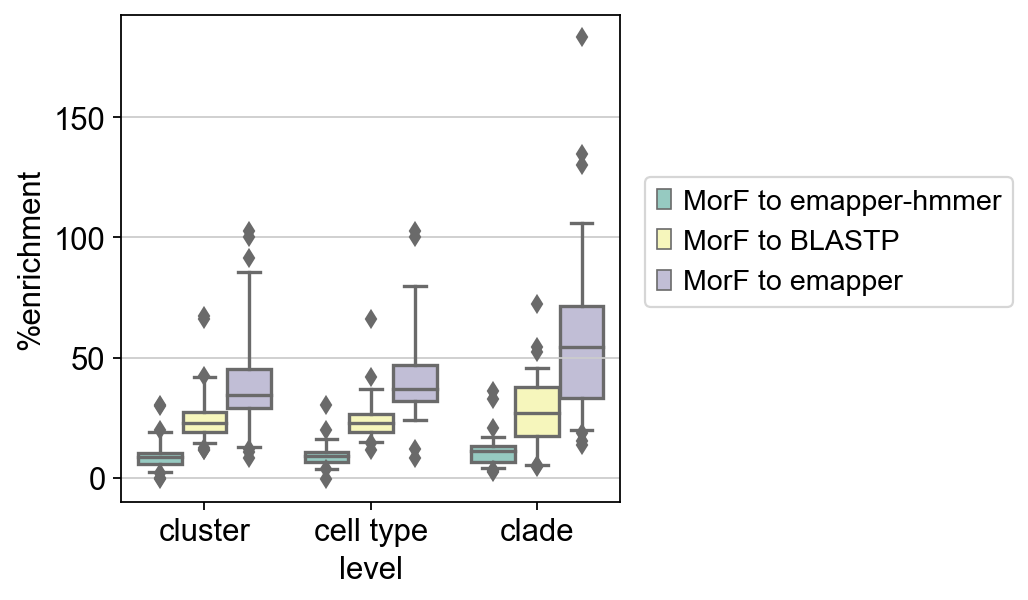

In [22]:
fig, ax = plt.subplots()
sns.boxplot(data=summary, x='level', y='%enrichment', hue='comparison', ax=ax, hue_order=['MorF to emapper-hmmer', 'MorF to BLASTP', 'MorF to emapper'], palette=cm.Set3.colors[:3], whis=[5, 95])
ax.legend(loc=[1.05, 0.4])
# ax.set_ylim(0, 150)
# plt.savefig('./analysis-enrichment.svg')

let's just plot the raw numbers for that:

In [23]:
raw = pd.concat([cluster_annot, celltype_annot, clade_annot], keys=['cluster', 'cell type', 'clade'])
raw.reset_index(inplace=True)
raw.columns = ['level', 'category', 'emapper + BLASTp', 'standard emapper', 'MorF', 'emapper-hmmer', 'MorF + sequence']

In [24]:
raw

level                      category  emapper + BLASTp  \
0    cluster                             1          0.760632   
1    cluster                             2          0.645000   
2    cluster                             3          0.675234   
3    cluster                             4          0.651413   
4    cluster                             5          0.600400   
..       ...                           ...               ...   
104    clade                     incPin1/2          0.338028   
105    clade                       incPin2          0.362869   
106    clade                 incPin_apnPin          0.434783   
107    clade             incPin_apnPin_Lph          0.461538   
108    clade  incPin_apnPin_Lph_Scp_basPin          0.589552   

     standard emapper      MorF  emapper-hmmer  MorF + sequence  
0            0.781288  0.873633       0.842041         0.877278  
1            0.625000  0.805000       0.750000         0.810000  
2            0.619159  0.794393       0.750000         0.801402  
3            0.567968  0.769852       0.706595         0.776581  
4            0.517483  0.727273       0.662338         0.733267  
..                ...       ...            ...              ...  
104          0.244131  0.441315       0.377934         0.450704  
105          0.261603  0.468354       0.413502         0.485232  
106          0.327231  0.521739       0.469108         0.530892  
107          0.323887  0.587045       0.518219         0.595142  
108          0.500000  0.619403       0.589552         0.626866  

[109 rows x 7 columns]

In [25]:
melted = pd.melt(raw, id_vars='level', value_vars=['emapper + BLASTp', 'standard emapper', 'emapper-hmmer', 'MorF'])

In [26]:
hmmer.shape

(28897, 22)

In [27]:
((hmmer['Description'] == '-') & (hmmer['Preferred_name'] == '-')).sum()

2473

In [30]:
melted = melted.append({'level': 'whole organism', 'variable': 'standard emapper', 'value': 17990/41943}, ignore_index=True)
melted = melted.append({'level': 'whole organism', 'variable': 'MorF', 'value': 25232/41943}, ignore_index=True)
melted = melted.append({'level': 'whole organism', 'variable': 'emapper + BLASTp', 'value': (17990 + 682)/41943}, ignore_index=True)
melted = melted.append({'level': 'whole organism', 'variable': 'emapper-hmmer', 'value': (28897-2473)/41943}, ignore_index=True)
# melted.append(['whole organism', 'CoFFE', ])
# melted.append(['whole organism', 'EggNOG-mapper + BLASTp', ])
# melted['level'] = melted['level'].str.replace(' ', '\n')

In [31]:
fig, ax = plt.subplots()
sns.boxplot(data=melted, x='level', y='value', hue='variable', ax=ax, hue_order=['standard emapper', 'emapper + BLASTp', 'emapper-hmmer', 'MorF'], 
            palette=cm.Set3.colors[:4], whis=[5, 95], order=['whole organism', 'clade', 'cell type'])
ax.legend(loc=[1.05, 0.4])
# ax.set_ylim(0, 150)
plt.savefig('./revision-percent_annotated.svg')